# MLDA Project - Predicting the default category risk for an individual
**Martin Španko and Nicholas Haak**

## Table of Contents
**1. [Introduction and Motivation](#introduction)** <br>
**2. [Data Exploration](#data_exploration)** <br>
**3. [Preprocessing](#preprocessing)** <br>

## 1. Introduction and Motivation <a name='introduction'></a>

### Context
This Jupyter Notebook was written by Martin Španko and Nicholas Haak as part of the group project in the course *Machine Learning and Data Analytics* at RWTH Aachen University. Given a dataset of german bank customers, the goal of this project is to apply and compare different classification methods to classify the risk of an individual in the categories *good* or *bad*. 

### Content of the dataset
This is a small overview of the attributes of the dataset. This information is provided with the dataset on https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk. A more detailed analysis of the data follows in Chapter [2. Data Exploration](#data_exploration).

Each row of the dataset represents a person who takes a loan at a bank. According to the given set of attributes, each person's risk is classified as either *good* or *bad*. These attributes are:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text: little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b> (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)<br>
<b>Risk </b> (Value target: good, bad)<br>

### Libraries
The necessary libraries are imported.

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches


In [169]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "text.color" : "black",
          "grid.color" : "w"}
plt.rcParams.update(params)

## 2. Data Exploration <a name='data_exploration'></a>

### Importing the dataset

In [170]:
df = pd.read_csv('german_credit_data.csv', index_col=0)
df.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


In [171]:
print(f'The dataset contains {df.shape[0]} entrys with {df.shape[1]} attributes.')

The dataset contains 1000 entrys with 10 attributes.


### Distribution of the attributes
With the following code, we will take a look at the distribution of all ten attributes. We will determine their datatype and how many entrys are empty. For numerical attributes, we will additionally derive their mean and standard deviation. This should give us a first insight into our dataset and how we will process the data for the classification task.

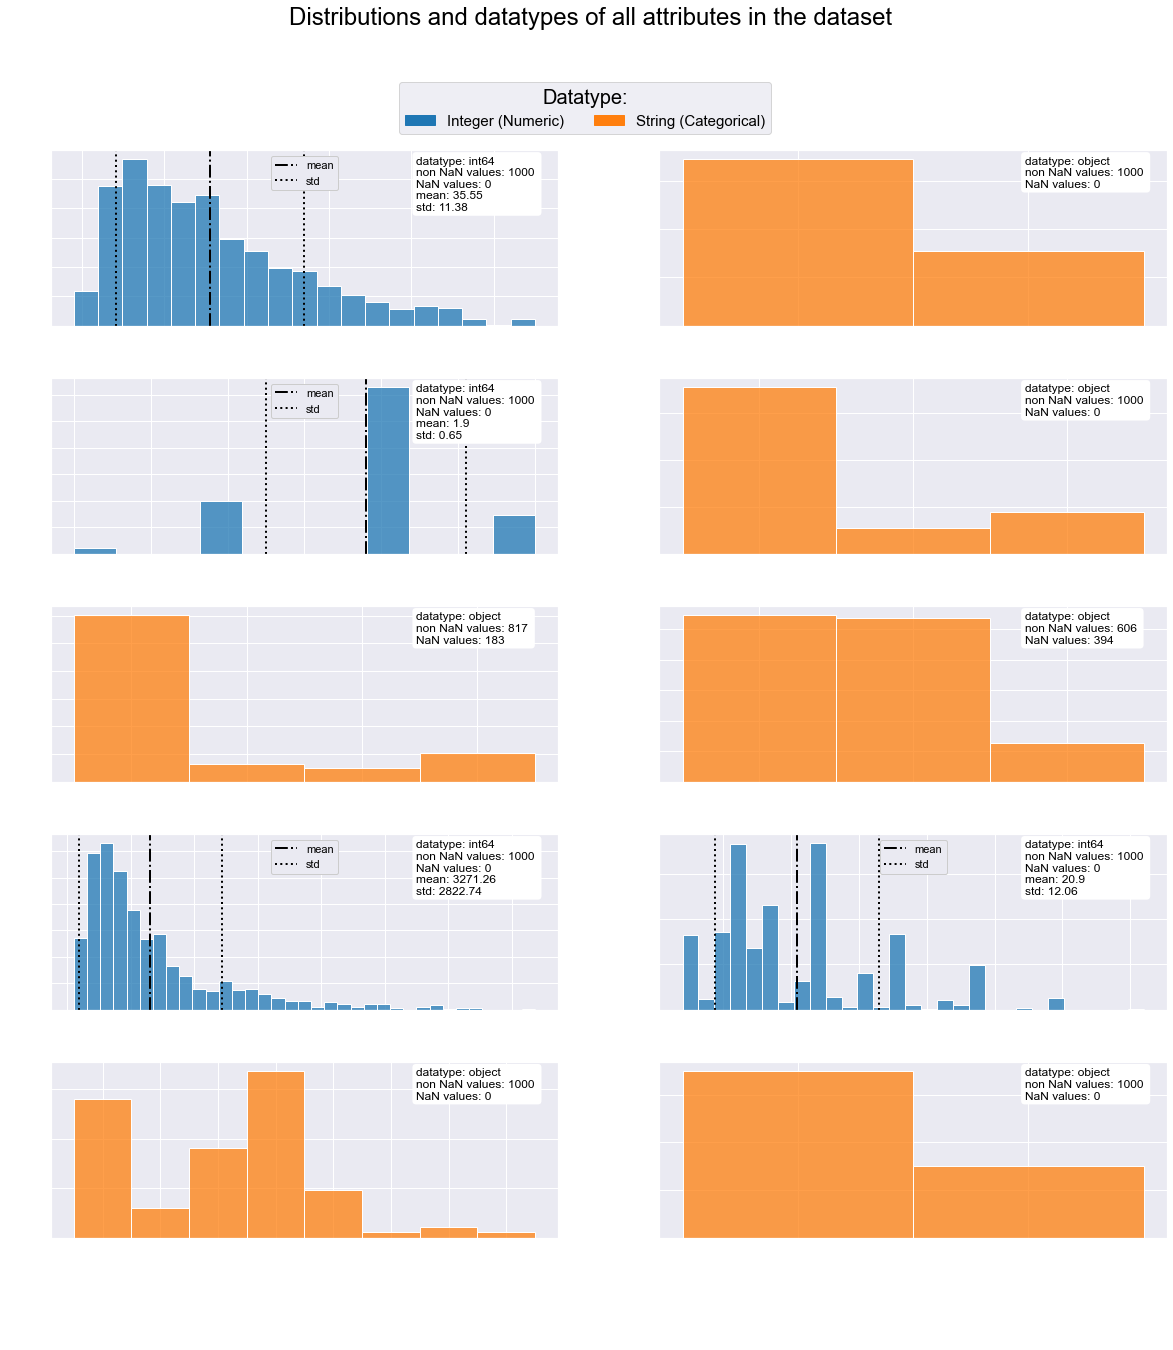

In [172]:
info_df = pd.DataFrame([df.dtypes, df.count(), df.shape[0] - df.count(), 
                        round(df.mean(numeric_only=True), 2), round(df.std(numeric_only=True), 2)])

fig, axes = plt.subplots(5,2, figsize=(20,20))

plt.subplots_adjust(hspace=0.3)

row = 0
col = 0
for attribute in list(df.columns):
    ax = axes[row][col]
    
    
    dtype = str(info_df[attribute].iloc[0])
    not_nan_count = str(info_df[attribute].iloc[1])
    nan_count = str(info_df[attribute].iloc[2])
    
    if dtype == 'int64':
        mean = str(info_df[attribute].iloc[3])
        std = str(info_df[attribute].iloc[4])
        additional_info = f'\nmean: {mean} \n' + f'std: {std}'
        color='tab:blue'
        ax.axvline(float(mean), 0, 1000, linestyle='-.', c='black', linewidth=2, label='mean')
        ax.axvline(float(mean) + float(std), 0, 1000, linestyle=':', c='black', linewidth=2, label='std')
        ax.axvline(float(mean) - float(std), 0, 1000, linestyle=':', c='black', linewidth=2)
        
        ax.legend(loc='upper center', framealpha=1)
    else:
        additional_info = ''
        color='tab:orange'

        
    sns.histplot(ax=ax, x=df[attribute], color=color, label=dtype)
    
    textstr = f'datatype: {dtype} \n' + f'non NaN values: {not_nan_count} \n' + f'NaN values: {nan_count}' + additional_info

    props = dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=1)
    ax.text(0.72, 0.97, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
    
    if col == 0:
        col += 1
    else:
        row += 1
        col -= 1
        
    if attribute == 'Purpose':
        ax.tick_params(labelrotation=45)
        
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(14)
    
        
numeric_patch = mpatches.Patch(color='tab:blue', label='Integer (Numeric)')
text_patch = mpatches.Patch(color='tab:orange', label='String (Categorical)')

fig.legend(handles=[numeric_patch, text_patch], title='Datatype:', loc=(0.34,0.9), fontsize=15, title_fontsize=20, ncol=2)
fig.suptitle('Distributions and datatypes of all attributes in the dataset', fontsize=24)


plt.show()

This first look has shown, that there are 4 attributes with the datatype integer and 6 attributes with the datatype string in this dataset. Given the variable description, we know that the attribute job is also categorial as it shows in the histogram aswell. Therefore, we can devide the attributes in the following groups: <br> <br>
**Numerical:** Age, Credit amount, Duration <br>
**Categorical:** Sex, Job, Housing, Savings account, Checking account, Purpose, Risk <br> <br>
This is important, because we will need to create dummy variables for the categorial variables, so that they can be used in classifying.

In [173]:
numerical_attributes = ['Age', 'Credit amount', 'Duration']
categorial_attributes = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

Let us see what kinds of categorial values there are:

In [174]:
for attr in categorial_attributes:
    print(f'{attr}: {list(df[attr].unique())}')

Sex: ['male', 'female']
Job: [2, 1, 3, 0]
Housing: ['own', 'free', 'rent']
Saving accounts: [nan, 'little', 'quite rich', 'rich', 'moderate']
Checking account: ['little', 'moderate', nan, 'rich']
Purpose: ['radio/TV', 'education', 'furniture/equipment', 'car', 'business', 'domestic appliances', 'repairs', 'vacation/others']
Risk: ['good', 'bad']


Let us also take a look at the numeric attributes:
**Why?**

In [175]:
df[numerical_attributes].describe().loc[['count','min', 'max']]

,Age,Credit amount,Duration
count,1000.0,1000.0,1000.0
min,19.0,250.0,4.0
max,75.0,18424.0,72.0


### Missing values
We will need to decide how to deal with missing values in the dataset.

There are 183 missing values in Saving account and 394 missing values in Checking account. All other values are plausible and do not require further attention. Let us take a look at the missing values:

In [176]:
missing = df.isnull().sum()
print(missing)

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [177]:
df[df.isnull().any(axis=1)].head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
2,49,male,1,own,little,NaN,2096,12,education,good
5,35,male,1,free,NaN,NaN,9055,36,education,good


In [178]:
df["Saving accounts"].fillna(df['Saving accounts'].mode()[0], inplace=True)
df["Checking account"].fillna(df['Checking account'].mode()[0], inplace=True)

If we were to just remove all rows with missing values, we would loose *478* rows and therefore *47.8 %* of our data entrys. We must find an alternative solution. This leads us to data imputation. There are several options to impute data for categorial columns. We replaced the missing data with modus. This would prevent a loss of data in a simple way. We chose this method based on this source: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e.

# Dummy variables

Next, we have to create dummy variables for the categorial variables, so that they can be used for classification. We make sure to set ``drop_first=True`` to get k-1 dummies out of k categorical levels. This reduces the number of dummies, while retaining all information.

In [179]:
df_dummies = pd.get_dummies(df, drop_first=True)

In [180]:
print(f'Our new dataset with dummies now has the shape ({df_dummies.shape[0]}, {df_dummies.shape[1]}). 12 new columns have been created from the qualitative attributes.')
df_dummies.head(3)

Our new dataset with dummies now has the shape (1000, 20). 12 new columns have been created from the qualitative attributes.


,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,67,2,1169,6,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,22,2,5951,48,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,49,1,2096,12,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


### Correlation analysis

For our machine learning techniques to work, we will need to find structure and dependencies in the data. To get a first look at the potential of our dataset, we will take a look at the correlation between all attributes.

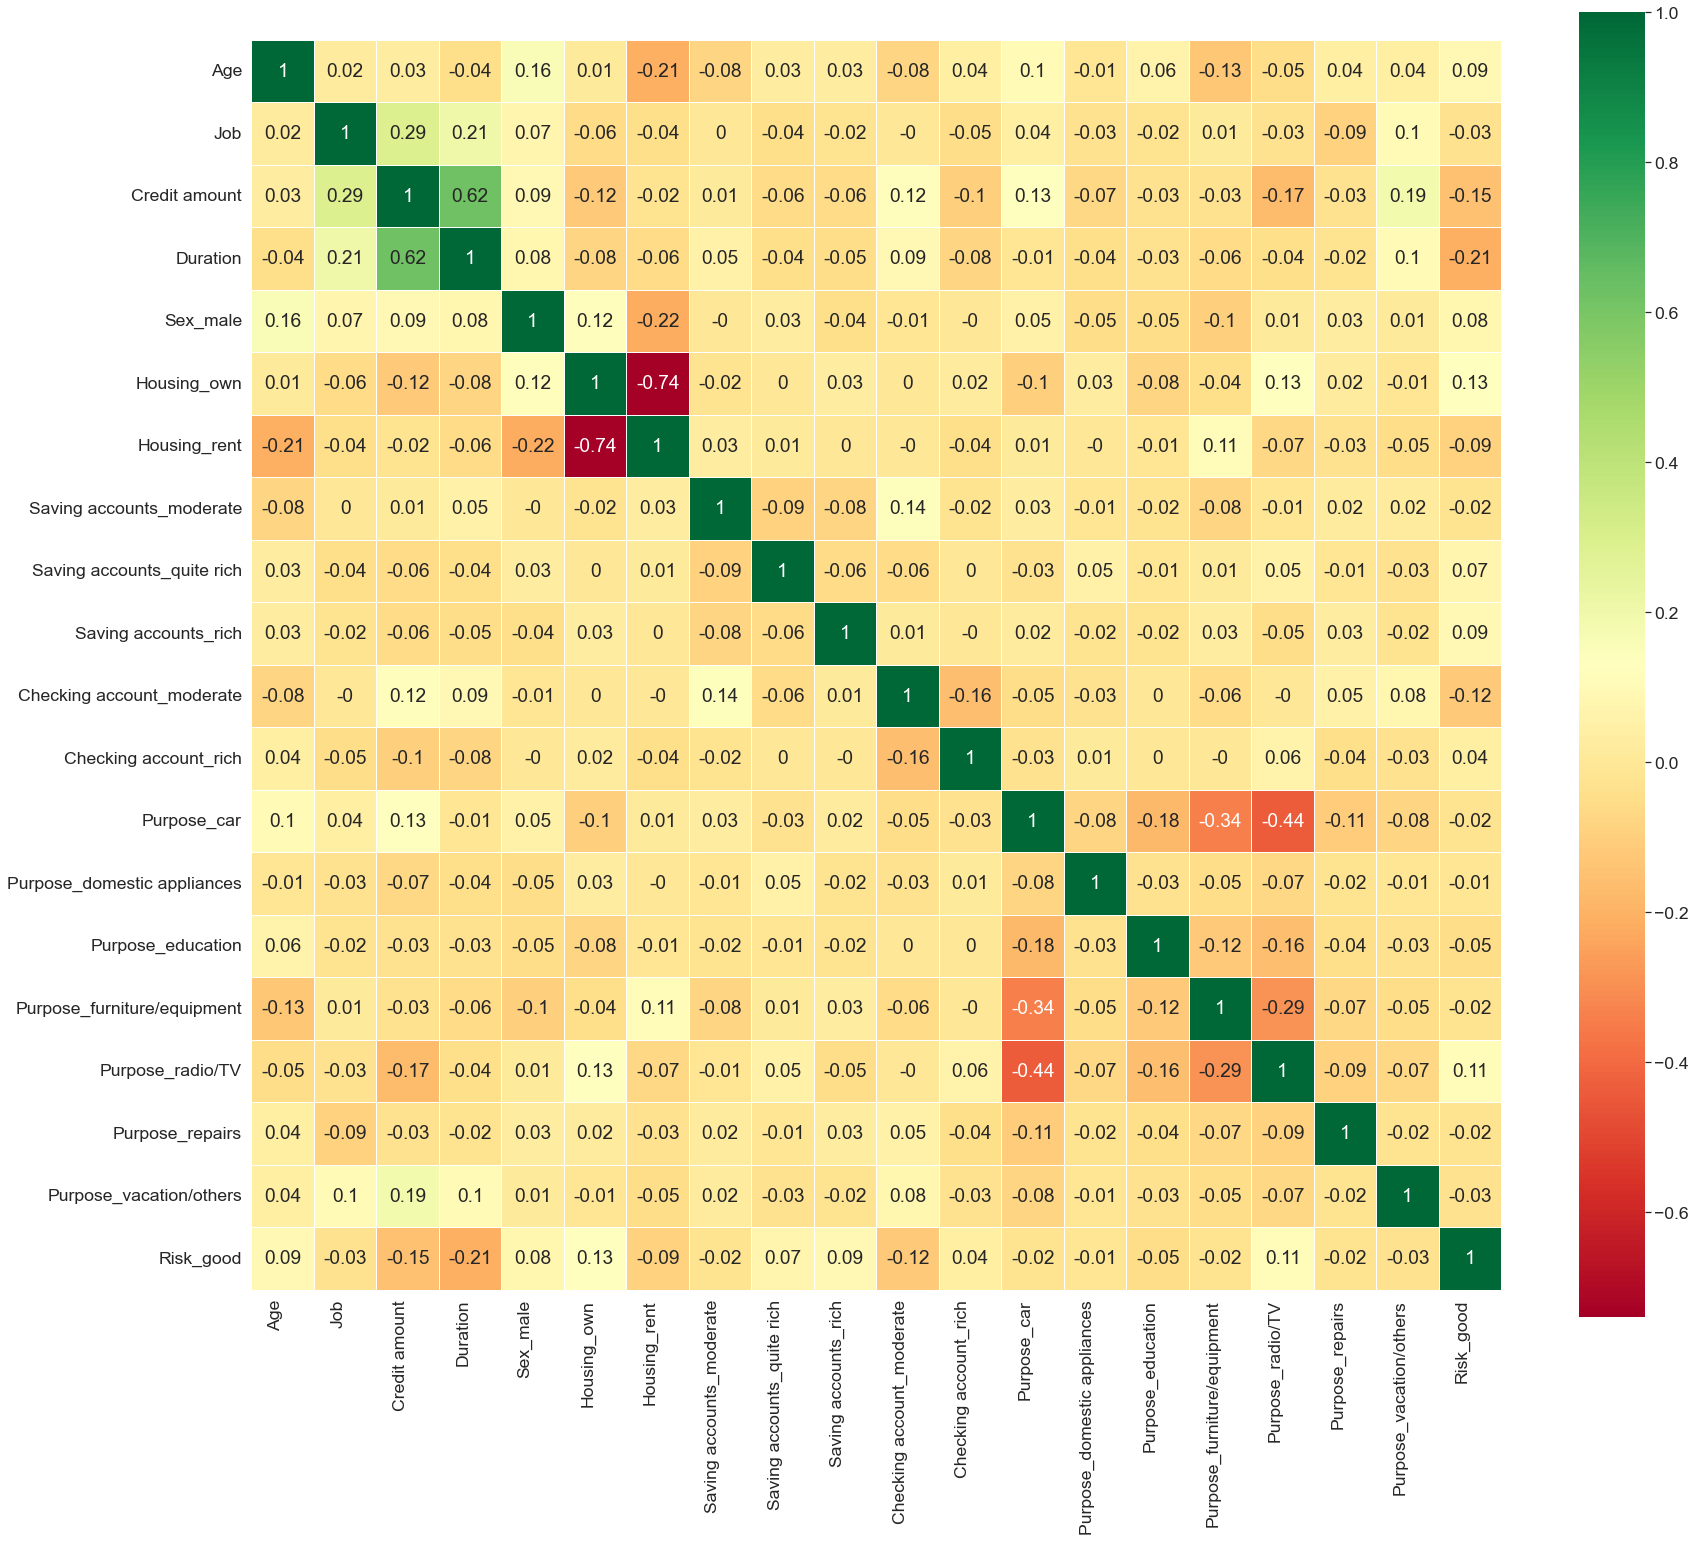

In [181]:
sns.set(font_scale=1.6)
corr = df_dummies.corr().round(2)
fig, ax = plt.subplots(figsize=(28,24))
h = sns.heatmap(corr, cmap=plt.cm.RdYlGn, annot=True, linewidths=1, square=True, ax=ax)
ax.set_ylim(len(corr),0)
h.set_xticklabels(h.get_xticklabels(), rotation=90, ha='right')
h.set_yticklabels(h.get_yticklabels(), rotation=0, ha='right')
sns.set(font_scale=1)

In [182]:
print('The correlations with Risk_good are:')
corr['Risk_good'].sort_values(ascending=False)[1:]

The correlations with Risk_good are:


Housing_own                    0.13
Purpose_radio/TV               0.11
Saving accounts_rich           0.09
Age                            0.09
Sex_male                       0.08
Saving accounts_quite rich     0.07
Checking account_rich          0.04
Purpose_domestic appliances   -0.01
Saving accounts_moderate      -0.02
Purpose_car                   -0.02
Purpose_furniture/equipment   -0.02
Purpose_repairs               -0.02
Job                           -0.03
Purpose_vacation/others       -0.03
Purpose_education             -0.05
Housing_rent                  -0.09
Checking account_moderate     -0.12
Credit amount                 -0.15
Duration                      -0.21
Name: Risk_good, dtype: float64

Clearly, there are many attributes with very low correlation to the target *Risk*. This suggests, that a strict subset selection may be useful.

Now that we know the correlations, it may be interesting to look at a few more visualizations. Since the bank account values are more correlated with the risk than many others, let us take a more detailed look at their categories. We will first group each attribute by the risk and then calculate how often there is a *good* risk in each category. 

In [183]:
checking_analysis = df.groupby(['Checking account', 'Risk'], dropna=False).count()['Age']
checking_index = checking_analysis.index.get_level_values(0).unique()
checking_percentages = [checking_analysis.iloc[i+1] / (checking_analysis.iloc[i] + checking_analysis.iloc[i+1]) for i in range(0,len(checking_analysis),2)]
checking_series = pd.Series(checking_percentages, index=checking_index)

savings_analysis = df.groupby(['Saving accounts', 'Risk'], dropna=False).count()['Age']
savings_index = savings_analysis.index.get_level_values(0).unique()
savings_percentages = [savings_analysis.iloc[i+1] / (savings_analysis.iloc[i] + savings_analysis.iloc[i+1]) for i in range(0,len(savings_analysis),2)]
savings_series = pd.Series(savings_percentages, index=savings_index)

percentages_df = pd.DataFrame(columns=['Checking account', 'Saving accounts'])
percentages_df['Checking account'] = checking_series * 100
percentages_df['Saving accounts'] = savings_series * 100

percentages_df

,Checking account,Saving accounts
Checking account,,
little,72.904192,68.320611
moderate,60.966543,66.990291
rich,77.777778,87.500000


The above dataframe now contains information about what percentage of the entrys have *good* risk dependent on the categories [little, moderate and rich] for both the checking account and saving accounts. Let us plot this and some other interesting attributes.

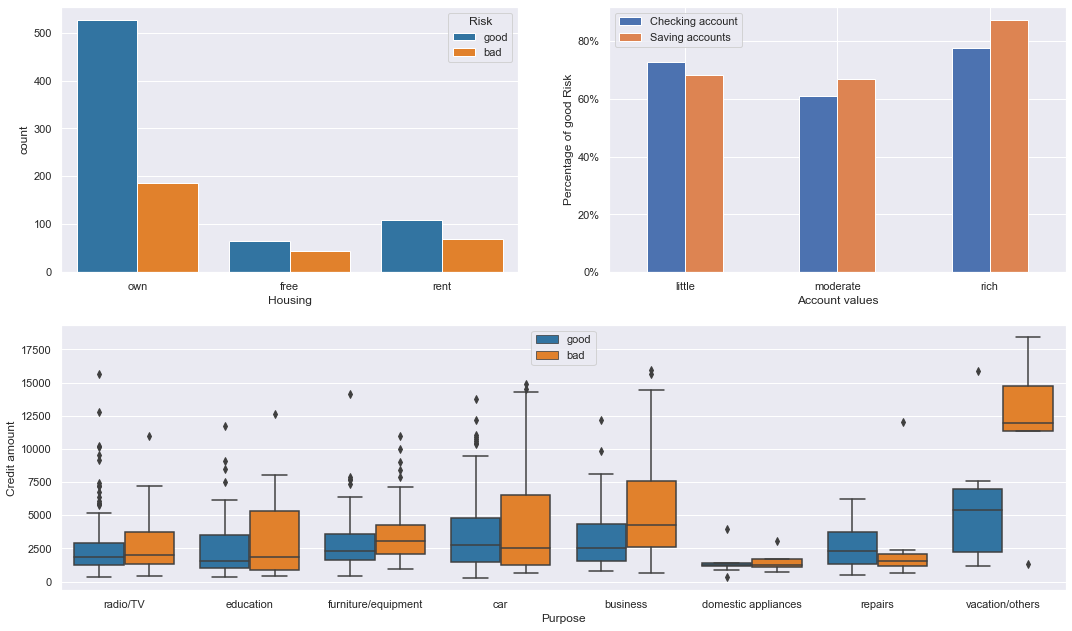

In [184]:
plt.figure(figsize = (18,12))

plt.subplot(221)
sns.countplot(x='Housing', hue='Risk', data=df, palette="tab10")

g2 = plt.subplot(222)
percentages_df.plot(ax=g2, kind='bar')
g2.set_ylabel('Percentage of good Risk')
g2.set_xlabel('Account values')
g2.yaxis.set_major_formatter(mtick.PercentFormatter())
g2.tick_params(axis='x', labelrotation=0)

g3 = plt.subplot(212)
sns.boxplot(x="Purpose", y="Credit amount", data=df, hue="Risk", palette="tab10")
g3.legend(loc='upper center')

plt.subplots_adjust(hspace = 0.2, wspace=0.2, top = 0.8)

plt.show()

Analyzing the outputs, it can be seen how both housing and account values are correlated to the risk. For example, a higher account value in both the checking and savings account, lead to a lower risk for the bank (a higher percentage of good risk).
Taking a look at the credit amount, you can see the negative correlation with the good risk clearly, as higher amounts are related to a *bad* risk more often. Furthermore, looking at the account values, it can be observed how missing values are correlated to a lower (*good*) risk aswell. This could be an indication that when there is no information about the account value, it is usually a high value and therefore more strongly correlated with a lower risk. This indicates that using the missing values for prediction may be useful.

## 3. Preprocessing <a name='preprocessing'></a>

Most of the machine learning algorithms need clean datasets to be provided as input to the algorithm.

But before getting to the clean data-set, we need to perform some extensive operations on the raw input datasets to finally arrive at the usable data-set.

### Checking the dataset
Firstly we checked the data type and created new dataframe to work with so we dont destroy the original one.

In [185]:
df_credit = df_dummies.copy()

In [186]:
df_credit.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,67,2,1169,6,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,22,2,5951,48,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,49,1,2096,12,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,45,2,7882,42,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,53,2,4870,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [187]:
df_credit.dtypes

Age                            int64
Job                            int64
Credit amount                  int64
Duration                       int64
Sex_male                       uint8
Housing_own                    uint8
Housing_rent                   uint8
Saving accounts_moderate       uint8
Saving accounts_quite rich     uint8
Saving accounts_rich           uint8
Checking account_moderate      uint8
Checking account_rich          uint8
Purpose_car                    uint8
Purpose_domestic appliances    uint8
Purpose_education              uint8
Purpose_furniture/equipment    uint8
Purpose_radio/TV               uint8
Purpose_repairs                uint8
Purpose_vacation/others        uint8
Risk_good                      uint8
dtype: object

### Standardization of variables

In order of process of scaling down the data and making it easier for the machine learning model to learn from it. We standardized the data using function StandardSclaer which tandardize features by removing the mean and scaling to unit variance.

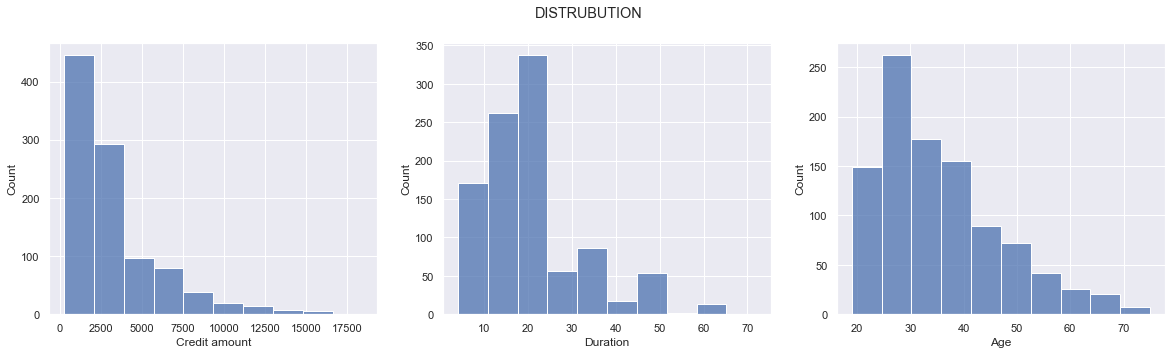

In [188]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRUBUTION')
sns.histplot(df_credit['Credit amount'], bins=10, ax=ax[0]);
sns.histplot(df_credit['Duration'], bins=10, ax=ax[1]);
sns.histplot(df_credit['Age'], bins=10, ax=ax[2],);

In [189]:
num_df_credit = df_credit[['Age', 'Duration', 'Credit amount']]
from sklearn import preprocessing
num_df = pd.DataFrame(data=preprocessing.StandardScaler().fit_transform(num_df_credit), columns=num_df_credit.columns)

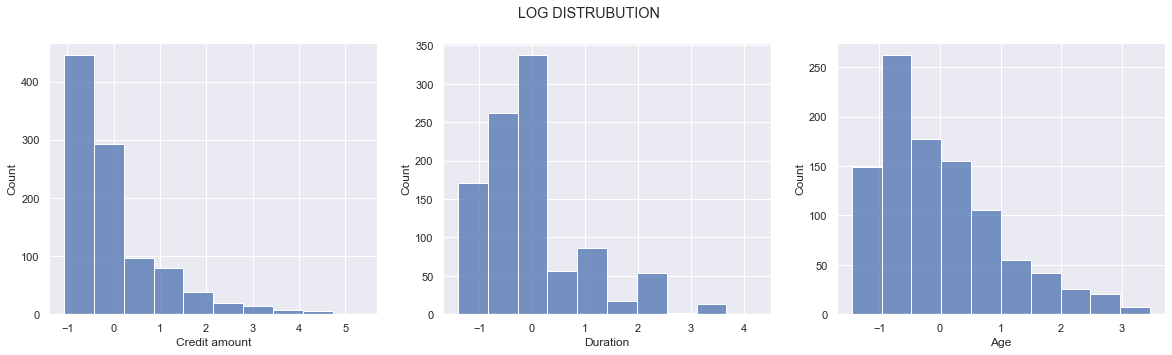

In [190]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('LOG DISTRUBUTION')
sns.histplot(num_df['Credit amount'], bins=10, ax=ax[0]);
sns.histplot(num_df['Duration'], bins=10, ax=ax[1]);
sns.histplot(num_df['Age'], bins=10, ax=ax[2],);

In [191]:
df_credit['Credit amount'] = num_df['Credit amount']
df_credit['Duration'] = num_df['Duration']
df_credit['Age'] = num_df['Age']

In [192]:
df_credit.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,2.766456,2,-0.745131,-1.236478,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,-1.191404,2,0.949817,2.248194,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1.183312,1,-0.416562,-0.738668,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.831502,2,1.634247,1.750384,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1.535122,2,0.566664,0.256953,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In last step we replaced the original variables by the sdandardized ones.

### Binning data

I fcked up do it in the night

### Splitting the dataset

Firstly we detached the explained variable Risk from the rest of variables.

In [193]:
# df_credit['Risk_good'] = df_credit['Risk']

In [194]:
# df_credit=df_credit.drop('Risk_good', axis=1)

In [195]:
x = df_credit.drop('Risk_good', axis=1)
y = df_credit['Risk_good']

Then we splitted the dataset into test and train frames using a function train_test_split.
The division ratio is 75% of data is train dataset and 25% is test dataset.

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV  
from sklearn.tree import DecisionTreeRegressor

In [197]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25 , random_state = 42)

In [198]:
x.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,2.766456,2,-0.745131,-1.236478,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-1.191404,2,0.949817,2.248194,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1.183312,1,-0.416562,-0.738668,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.831502,2,1.634247,1.750384,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1.535122,2,0.566664,0.256953,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [199]:
print('xtrain shape: ', x_train.shape)
print('xtest shape: ', x_test.shape)
print('ytrain shape: ', y_train.shape)
print('ytest shape: ', y_test.shape)

xtrain shape:  (750, 19)
xtest shape:  (250, 19)
ytrain shape:  (750,)
ytest shape:  (250,)


Lastly we checked if the division is successful.

### Cross validation

In [200]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score 
from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np

In [201]:
seed = 42

In [202]:
models = []
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))

LGR: 0.810877 (0.033639)
LDA: 0.806445 (0.033611)
QDA: 0.764554 (0.032973)
KNN: 0.782669 (0.037635)
CART: 0.717042 (0.056298)
NB: 0.761687 (0.034740)
RF: 0.801486 (0.049530)
SVM: 0.818094 (0.035774)
Mean f1 score: 0.7828567970694618


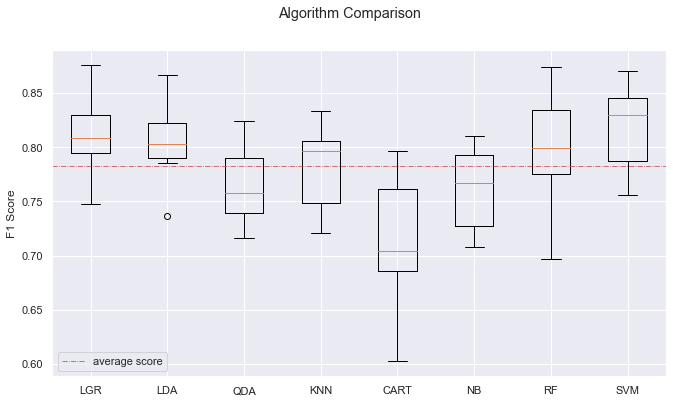

In [203]:
seed = 42
# evaluate each model in turn
results = []
names = []
# scoring = 'recall'
scoring = 'f1'

for name, model in models:
        cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

mean_score = np.mean([r.mean() for r in results])
print(f'Mean f1 score: {mean_score}')

fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
ax.set_ylabel('F1 Score')
ax.boxplot(results)
ax.axhline(y=mean_score, color='r', linestyle='-.', linewidth=0.8, label='average score')
ax.set_xticklabels(names)
ax.legend()

plt.show()

It can be observed, that Logistic Regression, Linear Discriminant Analysis, Random Forest and Support Vector Classification perform best.

### Logistic Regression

In [204]:
import statsmodels.api as sm
from sklearn import metrics

In [205]:
x_train_logit = sm.add_constant(x_train)
x_test_logit = sm.add_constant(x_test)

c:\Users\haakn\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [206]:
def logistic_regression(x_train, x_test, y_train, y_test, summary=True):

    logit = sm.Logit(y_train, x_train)
    results = logit.fit()
    
    if summary:
        print(results.summary())
    
    y_predicted = results.predict(x_test)
    y_predicted = y_predicted > 0.5
    cf_matrix = metrics.confusion_matrix(y_test, y_predicted)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    ax.set_title('Confusion Matrix\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ax.xaxis.set_ticklabels(['Risk bad','Risk good'])
    ax.yaxis.set_ticklabels(['Risk bad','Risk good'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

    print(f'recall: {metrics.recall_score(y_test, y_predicted)}')
    print(f'precision: {metrics.precision_score(y_test, y_predicted)}')
    # print(f'F1: {metrics.f1_score(y_test, y_predicted)}')
    print(f'accuracy: {metrics.accuracy_score(y_test, y_predicted)}')
    print(f'error rate: {1-metrics.accuracy_score(y_test, y_predicted)}')

c:\Users\haakn\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\haakn\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\haakn\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


Optimization terminated successfully.
         Current function value: 8.928928
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Risk_good   No. Observations:                  750
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                           19
Date:                Wed, 29 Jun 2022   Pseudo R-squ.:                     inf
Time:                        13:31:25   Log-Likelihood:                -6696.7
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0388      0.508      0.076      0.939   

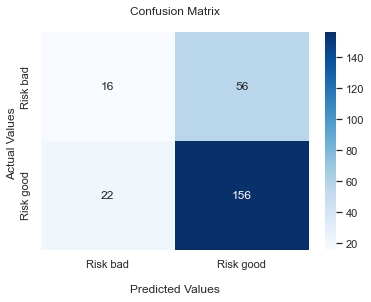

recall: 0.8764044943820225
precision: 0.7358490566037735
accuracy: 0.688
error rate: 0.31200000000000006


In [207]:
logistic_regression(x_train_logit, x_test_logit, y_train, y_test)

The attributes with p-value < 0.05 are: <br>
Age, Duration, Housing_own, Saving accounts_rich, Checking account_moderate <br>
Let us perform another regression using only these predictors

In [208]:
x_test_logit = x_test_logit[['const', 'Age', 'Duration', 'Housing_own', 'Saving accounts_rich', 'Checking account_moderate']]
x_train_logit = x_train_logit[['const', 'Age', 'Duration', 'Housing_own', 'Saving accounts_rich', 'Checking account_moderate']]


Optimization terminated successfully.
         Current function value: 6.144315
         Iterations 6


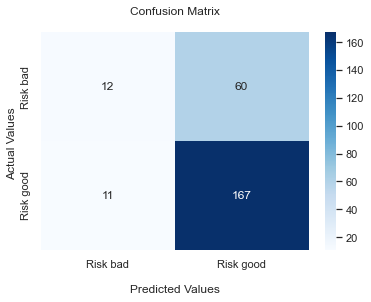

recall: 0.9382022471910112
precision: 0.73568281938326
accuracy: 0.716
error rate: 0.28400000000000003


In [209]:
logistic_regression(x_train_logit, x_test_logit, y_train, y_test, summary=False)

In [215]:
seed = 42
x_test = x_test[['Age', 'Duration', 'Housing_own', 'Saving accounts_rich', 'Checking account_moderate']]
x_train = x_train[['Age', 'Duration', 'Housing_own', 'Saving accounts_rich', 'Checking account_moderate']]

model = LogisticRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=seed)


cv_results = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
msg = f'mean: {cv_results.mean()}, std {cv_results.std()}'
print(msg)


mean: 0.7146666666666668, std 0.03873557079022387


### Best Subset Selection

In [258]:
from itertools import combinations
best_features = []
best_score = 0
all_scores = []
all_features = []

best_five = []
best_five_score = 0

p = x_train.shape[1]
for set_size in range(1, p+1):
    comb = combinations(x_train.columns, set_size)
    for feature_set in comb:
        x_restricted = x_train[list(feature_set)].values
        cv_results = cross_val_score(model, x_restricted, y_train, cv=cv, scoring='accuracy')
        score = cv_results.mean()

        if score > best_score:
            all_scores.append(score)
            all_features.append(feature_set)
            best_features = feature_set
            best_score = score

        if len(list(feature_set)) == 5:
            if score > best_five_score:
                best_five = feature_set
                best_five_score = score

all_scores.append(best_five_score)
all_features.append(best_five)

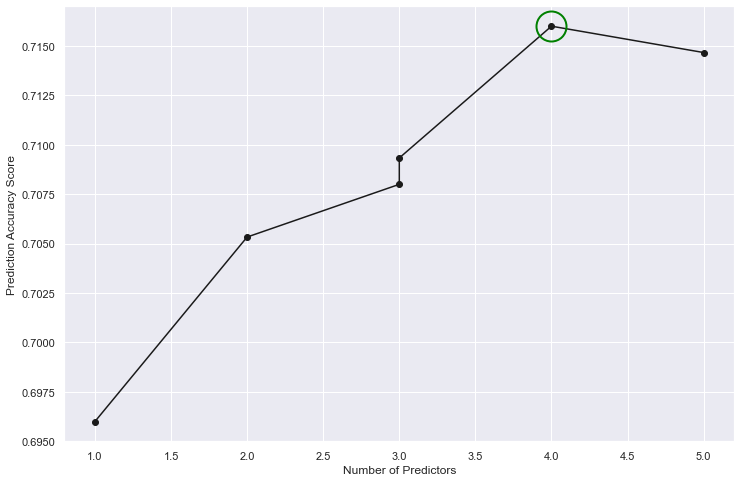

In [283]:
subset_size = [len(subset) for subset in all_features]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(subset_size, all_scores, 'k', marker='o')
ax.plot(all_scores.index(best_score), best_score, 'o', markersize=30, markeredgewidth=2, markerfacecolor="None",
         markeredgecolor='green')

ax.set_xlabel('Number of Predictors')
ax.set_ylabel('Prediction Accuracy Score')
plt.show()

In [285]:
print(f'In logistic regression the highest accuracy score of {best_score} is reached with the subset: \n {best_features}')

In logistic regression the highest accuracy score of 0.716 is reached with the subset: 
 ('Age', 'Duration', 'Housing_own', 'Checking account_moderate')
